Bagian 1: Import Library dan Load Dataset

In [18]:
# Bagian 1: Mengimpor library dan mengunggah dataset
# Tujuan: Untuk mengimpor library yang diperlukan dan memuat data "Online Retail" yang akan digunakan untuk clustering.

import numpy as np
import pandas as pd

# Membaca dataset
df = pd.read_csv('Online Retail.csv')

# Menampilkan informasi dasar dataset
# Insight: Ini akan memberi kita informasi dasar tentang struktur data, seperti kolom yang tersedia dan data yang hilang.
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Bagian 2: Data Preprocessing - Menghitung RFM Metrics

In [19]:
# Bagian 2: Menghitung metrik RFM
# Tujuan: Untuk mengidentifikasi kebiasaan belanja pelanggan dengan menghitung metrik Recency, Frequency, dan Monetary (RFM).

# Menghapus baris dengan CustomerID yang kosong
df = df.dropna(subset=['CustomerID'])

# Mengonversi kolom InvoiceDate menjadi datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Menentukan tanggal referensi untuk menghitung Recency
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Menghitung metrik RFM
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency (jumlah transaksi unik)
    'Quantity': 'sum',       # Total Quantity dibeli sebagai pengganti Monetary
    'UnitPrice': 'mean'      # Harga rata-rata untuk menghitung total spending
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'Quantity': 'Monetary'})

# Menghitung total pengeluaran (Monetary)
rfm_df['Monetary'] = rfm_df['Monetary'] * rfm_df['UnitPrice']
rfm_df = rfm_df.drop(columns='UnitPrice')  # Menghapus kolom UnitPrice setelah perhitungan

# Menampilkan data RFM yang telah diproses
# Insight: Data RFM membantu kita memahami kebiasaan belanja pelanggan berdasarkan kapan, seberapa sering, dan berapa banyak yang mereka belanjakan.
rfm_df.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.000000
12347.0,2,7,6498.979011
12348.0,75,4,13495.487419
12349.0,19,1,5230.384932
12350.0,310,1,756.711765


Bagian 3: Data Standardization

In [20]:
# Bagian 3: Menstandarisasi data
# Tujuan: Untuk membuat data pada skala yang sama agar clustering dapat bekerja dengan optimal.

from sklearn.preprocessing import StandardScaler

# Inisialisasi StandardScaler dan menerapkannya pada data RFM
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df)

# Mengonversi kembali hasil scaling ke dalam DataFrame untuk kemudahan interpretasi
scaled_rfm_df = pd.DataFrame(rfm_scaled, columns=rfm_df.columns, index=rfm_df.index)

# Menampilkan data RFM yang telah dinormalisasi
# Insight: Standarisasi memastikan bahwa setiap fitur memiliki bobot yang setara dalam proses clustering.
scaled_rfm_df.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,2.322023,-0.329362,-0.090581
12347.0,-0.893733,0.206102,0.026085
12348.0,-0.169196,-0.115176,0.151682
12349.0,-0.725005,-0.436455,0.003312
12350.0,2.163220,-0.436455,-0.076997


Bagian 4: Fungsi Evaluasi Clustering

In [21]:
# Bagian 4: Mendefinisikan fungsi evaluasi clustering
# Tujuan: Untuk mengevaluasi model clustering menggunakan Elbow (Knee), Silhouette Score, serta tambahan metrik lain (Davies-Bouldin Index).

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def evaluate_clustering(data, model, model_name, k_range=range(2, 11)):
    """Evaluasi model clustering menggunakan Elbow, Silhouette Score, Davies-Bouldin Index, dan Calinski-Harabasz Index."""

    inertias = []       # Untuk Elbow (Knee)
    silhouettes = []    # Untuk Silhouette Score
    davies_bouldins = [] # Untuk Davies-Bouldin Index
    calinski_harabaszs = [] # Untuk Calinski-Harabasz Index

    for k in k_range:
        clustering_model = model(n_clusters=k)
        labels = clustering_model.fit_predict(data)

        # Menghitung inertia untuk Elbow (khusus KMeans) atau total jarak untuk model lain
        if model_name == 'K-Means':
            inertias.append(clustering_model.inertia_)
        else:
            centroids = [data[labels == cluster].mean(axis=0) for cluster in range(k)]
            inertia = np.sum([cdist([centroids[label]], [point], 'euclidean').sum()
                              for label, point in zip(labels, data)])
            inertias.append(inertia)

        # Menghitung Silhouette Score
        silhouettes.append(silhouette_score(data, labels))

        # Menghitung Davies-Bouldin Index
        davies_bouldins.append(davies_bouldin_score(data, labels))

        # Menghitung Calinski-Harabasz Index
        calinski_harabaszs.append(calinski_harabasz_score(data, labels))

    # Menampilkan grafik Elbow (Knee) dan Silhouette Score
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(k_range, inertias, marker='o')
    ax[0].set_title(f'Elbow Method for {model_name}')
    ax[0].set_xlabel('Number of Clusters')
    ax[0].set_ylabel('Inertia')

    ax[1].plot(k_range, silhouettes, marker='o', color='orange')
    ax[1].set_title(f'Silhouette Score for {model_name}')
    ax[1].set_xlabel('Number of Clusters')
    ax[1].set_ylabel('Silhouette Score')

    plt.show()

    # Menampilkan Davies-Bouldin dan Calinski-Harabasz sebagai tambahan metrik
    print(f"Davies-Bouldin Index for {model_name}: {davies_bouldins}")
    print(f"Calinski-Harabasz Index for {model_name}: {calinski_harabaszs}")

    # Menampilkan jumlah cluster optimal berdasarkan Silhouette Score tertinggi
    optimal_k = k_range[np.argmax(silhouettes)]
    print(f"Optimal jumlah cluster untuk {model_name} adalah: {optimal_k}")


Bagian 5: Evaluasi K-Means Clustering

Evaluating K-Means Clustering...


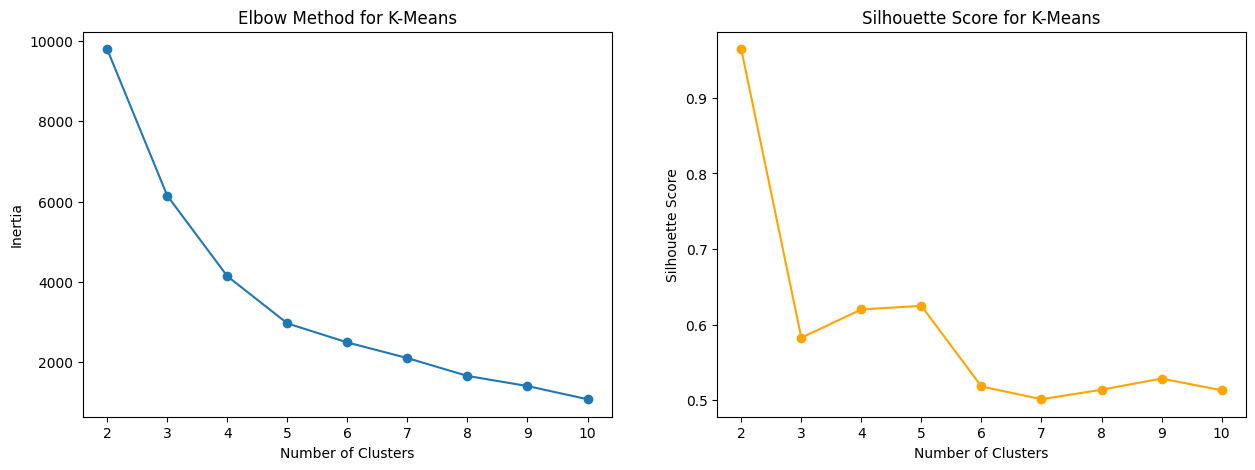

Davies-Bouldin Index for K-Means: [0.2884293221124656, 0.5043629483492605, 0.6230226992901949, 0.5830249178679974, 0.5908492510730937, 0.6111917215855481, 0.5892234745683953, 0.4895240050686264, 0.5014994134048183]
Calinski-Harabasz Index for K-Means: [1480.7594506738305, 2474.882121363261, 3153.51838440095, 3735.4849139551006, 3724.216050678588, 3812.860252086791, 4311.0144004011945, 4546.820319751595, 5419.925733997259]
Optimal jumlah cluster untuk K-Means adalah: 2


In [22]:
# Evaluasi K-Means Clustering
print("Evaluating K-Means Clustering...")
evaluate_clustering(rfm_scaled, KMeans, "K-Means")

Bagian 6: Evaluasi Euclidean Clustering (Agglomerative Clustering dengan Euclidean Distance)

Evaluating Euclidean Clustering...


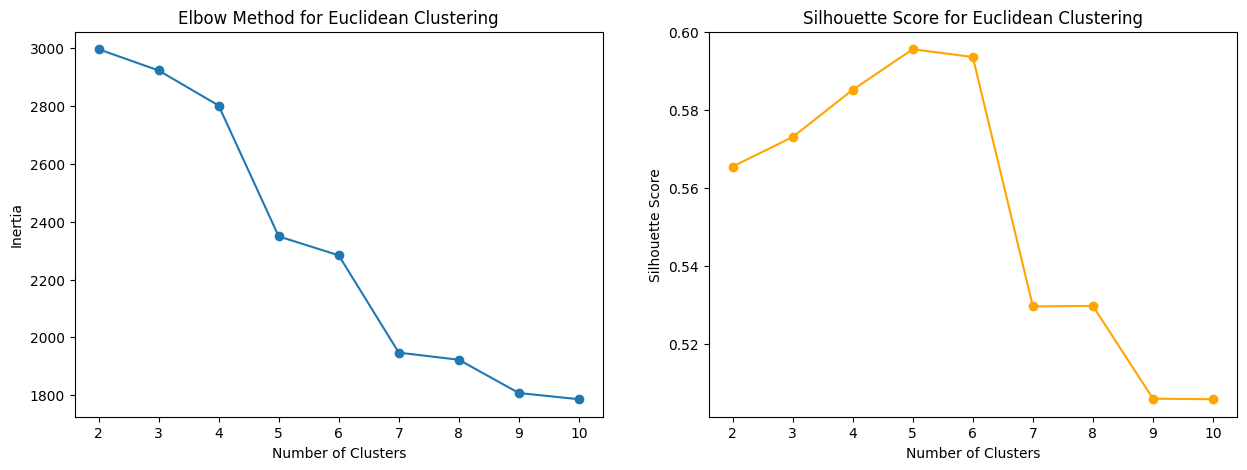

Davies-Bouldin Index for Euclidean Clustering: [0.6561440871354544, 0.5214440742363867, 0.5165973029622619, 0.6211665850910416, 0.6507209424604011, 0.644585747914335, 0.5996684632154221, 0.6080870479443843, 0.5299560883262175]
Calinski-Harabasz Index for Euclidean Clustering: [1673.554871807533, 2458.467318649179, 2991.930759200542, 3555.577484420063, 3776.243413461849, 4001.5523845810003, 4111.508292922881, 4405.381223858419, 4746.70023475264]
Optimal jumlah cluster untuk Euclidean Clustering adalah: 5


In [25]:
# Evaluasi Euclidean Clustering
print("Evaluating Euclidean Clustering...")
evaluate_clustering(rfm_scaled, AgglomerativeClustering, "Euclidean Clustering")

Bagian 7: Evaluasi Hierarchical Clustering

Evaluating Hierarchical Clustering...


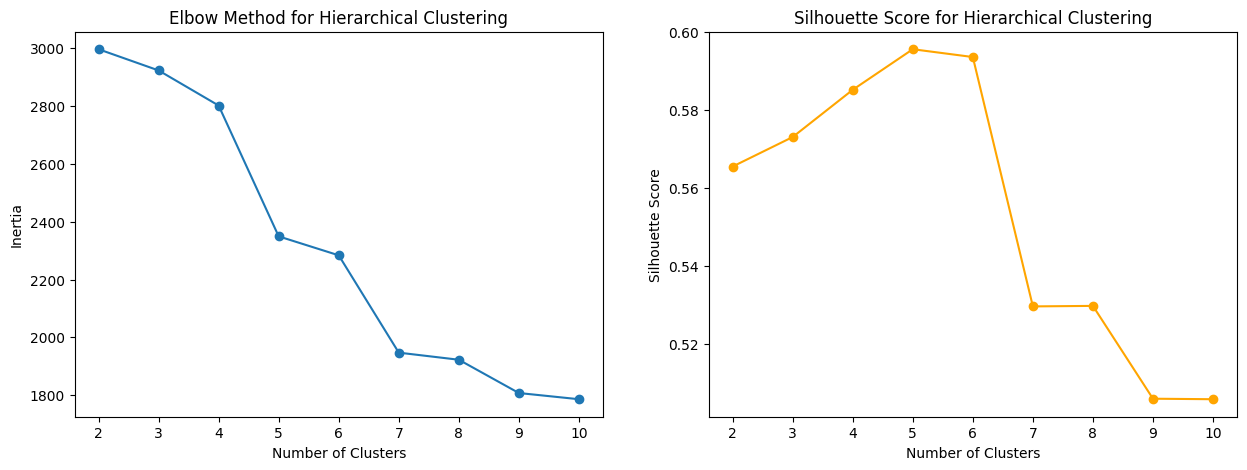

Davies-Bouldin Index for Hierarchical Clustering: [0.6561440871354544, 0.5214440742363867, 0.5165973029622619, 0.6211665850910416, 0.6507209424604011, 0.644585747914335, 0.5996684632154221, 0.6080870479443843, 0.5299560883262175]
Calinski-Harabasz Index for Hierarchical Clustering: [1673.554871807533, 2458.467318649179, 2991.930759200542, 3555.577484420063, 3776.243413461849, 4001.5523845810003, 4111.508292922881, 4405.381223858419, 4746.70023475264]
Optimal jumlah cluster untuk Hierarchical Clustering adalah: 5


In [24]:
# Evaluasi Hierarchical Clustering
print("Evaluating Hierarchical Clustering...")
evaluate_clustering(rfm_scaled, AgglomerativeClustering, "Hierarchical Clustering")